# Stable Baselines, a Fork of OpenAI Baselines - Monitor Training and Plotting

Github Repo: [https://github.com/hill-a/stable-baselines](https://github.com/hill-a/stable-baselines)

Medium article: [https://medium.com/@araffin/stable-baselines-a-fork-of-openai-baselines-df87c4b2fc82](https://medium.com/@araffin/stable-baselines-a-fork-of-openai-baselines-df87c4b2fc82)

## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```

sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```

pip install stable-baselines
```

In [0]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines==2.1.1 box2d box2d-kengz

## Import policy, RL agent, Wrappers

In [0]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines.ddpg.policies import MlpPolicy
from stable_baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import DDPG
from stable_baselines.ddpg.noise import AdaptiveParamNoiseSpec

## Define a Callback Function


In [0]:
best_mean_reward, n_steps = -np.inf, 0

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        # Evaluate policy performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return False

## Create and wrap the environment

We will be using Lunar Lander environment with continuous actions

In [0]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('LunarLanderContinuous-v2')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Define and train the DDPG agent

In [0]:
# Add some param noise for exploration
param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.2, desired_action_stddev=0.2)

model = DDPG(MlpPolicy, env, param_noise=param_noise, memory_limit=int(1e6), verbose=0)
# Train the agent
model.learn(total_timesteps=100000, callback=callback)

## Plotting helpers

In [0]:
def movingAverage(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = movingAverage(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()


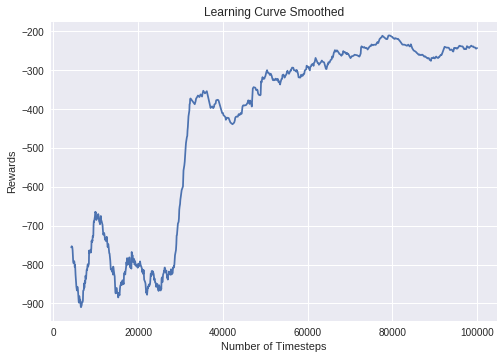

In [0]:
plot_results(log_dir)